In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

from matplotlib.colors import Normalize

## Load in the Image

In [20]:
img1 = plt.imread("./Test_NT_A_SE1.tif")
img2 = plt.imread("./Test_NT_B_SE2.tif")

Recimg1 = plt.imread("./Test_NR_A.tif")
Recimg2 = plt.imread("./Test_NR_B.tif")

## View the Image

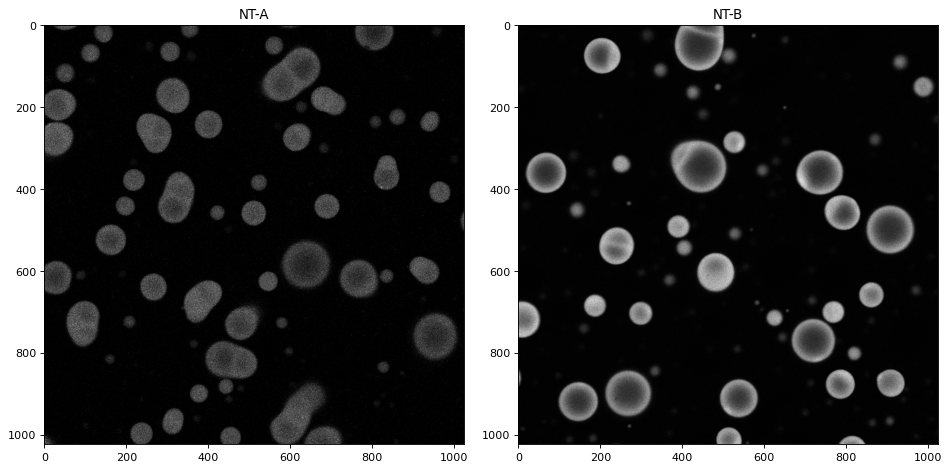

In [21]:
plt.figure(figsize = (12, 6), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("NT-A")
plt.imshow(img1, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.title("NT-B")
plt.imshow(img2, cmap = 'gray')

plt.tight_layout()
plt.show()

## Droplet Detection

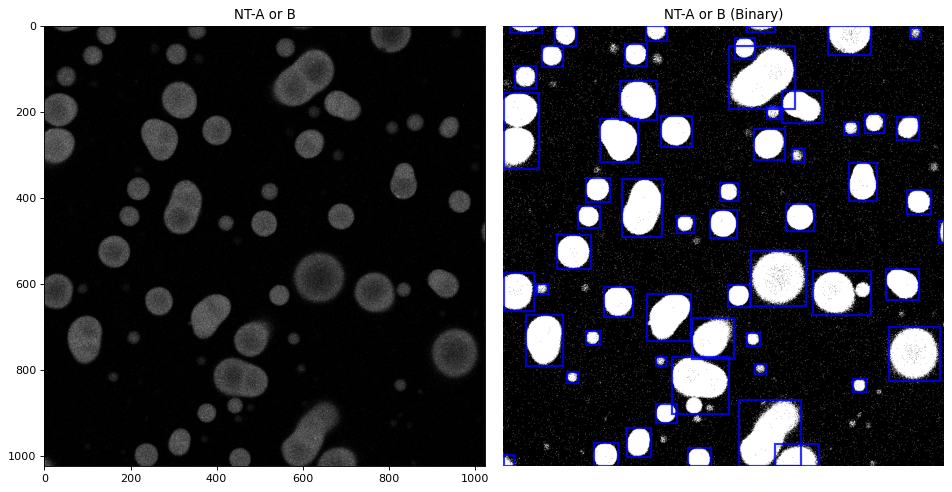

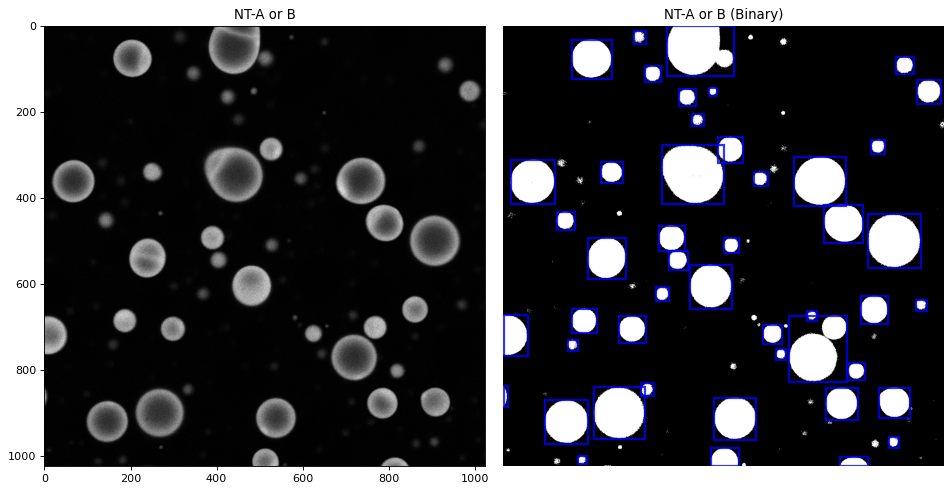

In [22]:
# Create Binary for better signal to noise

def detection(img1):
    binary = img1 > (img1.mean() + 0.01*img1.std())

    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    droplets = [i for i in blob_lists if i.area > 200]

    plt.figure(figsize = (12, 6), dpi = 80)

    plt.subplot(1, 2, 1)
    plt.title("NT-A or B")
    plt.imshow(img1, cmap = 'gray')

    ax = plt.subplot(1, 2, 2)
    plt.title("NT-A or B (Binary)")
    plt.imshow(binary, cmap = 'gray')
    for i in droplets:
        minr, minc, maxr, maxc = i.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2, alpha=.8)
        ax.add_patch(rect)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()
    
    return(droplets)

droplets_1 = detection(img1)
droplets_2 = detection(img2)


## Value Extraction

In [23]:
def calc(droplets, Recimg1, Recimg2):
    # calculate the intensities of atto (NR-A) and txrd (NR-B) in droplets
    atto, txrd = [], []

    for droplet in droplets:

        # get te location to crop
        minr, minc, maxr, maxc = droplet.bbox
        
        # crop the droplet from the img u wanna measure
        cropped_img = Recimg1[minr:maxr, minc:maxc]
        # get the mask of the drolet
        mask = binary_dilation(droplet.image)
        # aply the mask so bg is val removed
        extracted_val = cropped_img[mask]
        atto.append(extracted_val)

        # crop the droplet from the img u wanna measure
        cropped_img = Recimg2[minr:maxr, minc:maxc]
        # get the mask of the drolet
        mask = binary_dilation(droplet.image)
        # aply the mask so bg is val removed
        extracted_val = cropped_img[mask]
        txrd.append(extracted_val)

    threshold = 3000
    
    # flatten
    atto = [val for ary in atto for val in ary]
    txrd = [val for ary in txrd for val in ary]
    
    atto_true, txrd_true = [], []
    
    for i_ in range(len(atto)):
        if atto[i_] > threshold:
            if txrd[i_] > threshold:
                atto_true.append(atto[i_])
                txrd_true.append(txrd[i_])
    
    return atto_true, txrd_true

atto_1, txrd_1 = calc(droplets_1, Recimg1, Recimg2)
atto_2, txrd_2 = calc(droplets_2, Recimg1, Recimg2)
atto_total = np.concatenate((atto_1, atto_2))
txrd_total = np.concatenate((txrd_1, txrd_2))

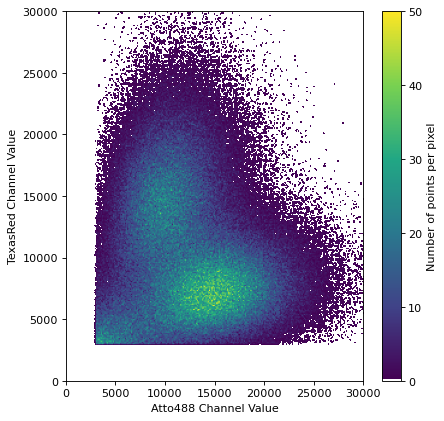

In [24]:
import mpl_scatter_density
from matplotlib.colors import Normalize

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

fig = plt.figure(figsize=(6, 6), dpi = 80)
axi = fig.add_subplot(1, 1, 1, projection='scatter_density')
min_value = 0
max_value = 50
norm = Normalize(vmin=min_value, vmax=max_value)
density = axi.scatter_density(atto_total,\
                              txrd_total,\
                              cmap=white_viridis, norm = norm)

fig.colorbar(density, label='Number of points per pixel')
# plt.title("Before Transcription")
plt.ylabel("TexasRed Channel Value")
plt.xlabel("Atto488 Channel Value")
# "Viridis-like" colormap with white background
plt.xlim(0, 30000)
plt.ylim(0, 30000)

plt.savefig('Txn_25min_NR-A_NR-B_withlines.png', dpi=400)
plt.show()

In [27]:
# fluorescence statistics
print(np.mean(atto_1))
print(np.std(atto_1))

print(np.mean(atto_2))
print(np.std(atto_2))

print(np.mean(txrd_1))
print(np.std(txrd_1))

print(np.mean(txrd_2))
print(np.std(txrd_2))

14798.15089430195
4750.623407851588
9966.256084232466
3461.0398288030055
7421.388589922101
2526.390732604021
13954.4547320396
4928.458903880464


In [28]:
df_atto1 = pd.DataFrame({"Atto_NSD1": atto_1})
df_atto2 = pd.DataFrame({"Atto_NSD2": atto_2})
df_txrd1 = pd.DataFrame({"TXRD_NSD1": txrd_1})
df_txrd2 = pd.DataFrame({"TXRD_NSD2": txrd_2})


In [29]:
df_atto1.to_csv("Atto_NSD1_Testn.csv")
df_atto2.to_csv("Atto_NSD2_Test.csv")
df_txrd1.to_csv("TXRD_NSD1_Test.csv")
df_txrd2.to_csv("TXRD_NSD2_Test.csv")